# Exploratory Analysis of the CAPE ratio when applied on a country level

### What is the CAPE ratio
The CAPE ratio is a valuation measure that uses real earnings per share (EPS) over a 10-year period. Unlike the traditional TTM PE ratio, the CAPE ratio covers a timespan that includes multiple stages of the business cycle, making it a better measure of past performance of future returns of a stock. 

The CAPE ratio can also be applied to a country's market cap weighted index. From this, we can look at what the historical values have been, and how the historical lows and highs affect future returns.

### Background
Multiple studies and historical analysis point towards the effectiveness of the CAPE ratios in predicting future stock market returns. 

In a paper by [Star Capital](https://www.starcapital.de/fileadmin/user_upload/files/publikationen/Research_2016-01_Predicting_Stock_Market_Returns_Shiller_CAPE_Keimling.pdf), they show that an inverse correlation exists between the CAPE ratio and the future 10-15 year returns using data that goes back to 1979 for the world markets and 1881 for the US stock market. 

In this [blog post](https://mebfaber.com/2019/01/06/you-would-have-missed-961-in-gains-using-the-cape-ratio-and-thats-a-good-thing/), Meb Faber takes it a step further and shows how a CAPE switching strategy would have performed between 1993 and 2018 against other SP500 and bond buy-and-hold strategies. 

Both studies omit the inclusion of the data that was used for the analysis or the code that was used to generate their results. This makes it hard to replicate and analyze their methodology. For this reason, all code and data used in this analysis will be made available alongside the notebook. 

### Datasets
- Historcal CAPE ratios for different countries going all the way back up to 1982. Data compiled and calculated by Barclays. Contains a total of 25 countries. Monthly granularity.

- Stock market return of MSCI indices for each of the 25 countries. Data is gross returns (dividends reinvested, not adjusted for inflation). Returns measured in USD, not local currencies.

- Yearly returns for a wide array of assets compiled by backtestportfolio. USD inflation rates, US bond returns, and Global bond returns going all the way back to 1972 are extracted from here.

- Lack country market caps/country weights. 


In [1]:
import os
import math
import pandas as pd
import numpy as np
import functools
import helper
import pprint
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

pp = pprint.PrettyPrinter()

#### Import Data
`yearly_cape` contains yearly values of the CAPE ratios as measured by Barclays using the MSCI indexes.

`asset_returns` contains returns of multiple asset groups in USD going back to 1970s, we will get the USD inflation rate from here. 

`year_percentage_returns` contains the USD gross values (adjusting for dividends reinvestments) of the stock market indexes for each of the countries used in this analysis, they are not inflation adjusted.

In [2]:
yearly_cape = helper.ingest_cape_data()
asset_returns = helper.ingest_asset_returns()
year_percentage_returns = helper.compute_yearly_percentage(asset_returns['Bonds'])

#### Print out data

In [3]:
yearly_cape.tail()

,Australia,Brazil,Canada,China,France,Germany,Hong Kong,India,Israel,Italy,...,Russia,Singapore,South Africa,Spain,Sweden,Switzerland,Taiwan,Turkey,United Kingdom,USA
Date,,,,,,,,,,,,,,,,,,,,,
2015,19.75,10.36,21.15,15.61,18.14,21.42,20.12,22.44,17.05,12.93,...,5.62,16.23,24.52,14.62,23.80,24.03,22.96,13.32,14.69,25.11
2016,17.24,8.39,18.37,11.40,18.19,18.58,15.48,18.62,17.52,12.88,...,5.50,12.53,20.77,12.51,20.12,23.86,18.58,10.01,13.46,23.58
2017,19.96,12.80,22.58,13.45,20.66,20.62,17.73,19.75,14.04,14.66,...,7.01,14.51,20.59,14.48,22.80,24.87,21.40,10.63,16.57,27.08
2018,21.29,17.04,23.09,20.55,24.26,23.36,21.70,24.14,14.40,21.29,...,7.96,17.52,23.43,17.15,23.52,29.34,24.17,12.94,18.05,32.36
2019,20.44,19.69,22.46,15.68,22.03,18.76,19.03,22.99,14.94,19.80,...,8.73,15.80,20.63,15.20,21.55,26.83,20.56,9.54,17.26,28.74


In [4]:
year_percentage_returns.head()

,Italy,Turkey,Spain,United Kingdom,France,Switzerland,Mexico,Japan,Korea,Canada,...,Germany,Hong Kong,Brazil,Netherlands,Russia,Singapore,Sweden,Taiwan,Poland,Bonds
Date,,,,,,,,,,,,,,,,,,,,,
1969,1.041800,NaN,1.039400,0.993800,1.039400,0.975000,NaN,0.984900,NaN,1.024900,...,0.952300,1.055900,NaN,0.946400,NaN,0.989800,0.962300,NaN,NaN,NaN
1970,0.801977,NaN,0.989128,0.952204,0.959303,0.970462,NaN,0.949843,NaN,1.168114,...,0.915258,1.444928,NaN,1.013736,NaN,1.034552,0.904500,NaN,NaN,NaN
1971,0.901975,NaN,1.239082,1.558174,1.030488,1.268125,NaN,1.585890,NaN,1.156281,...,1.169573,1.523563,NaN,1.067230,NaN,1.641895,1.321347,NaN,NaN,NaN
1972,1.027203,NaN,1.444854,0.922143,1.255085,1.237270,NaN,2.136155,NaN,1.270751,...,1.175593,3.101355,NaN,1.269948,NaN,3.465949,1.171637,NaN,NaN,1.0235
1973,1.144426,NaN,1.229490,0.757520,0.970689,0.951031,NaN,0.782469,NaN,1.001137,...,0.942173,0.549722,NaN,0.889641,NaN,0.593311,1.009722,NaN,NaN,1.0329


#### Comparing CAPE to 1-year returns

Let's plot and compare the CAPE ratios to their one year returns. If CAPE is truly a good indicator of cheapness for a country stock index, we should see a correlation between low CAPE and future high returns. 

1-year CAPE vs returns

1-year cape vs return correlation: -0.2166129209033585


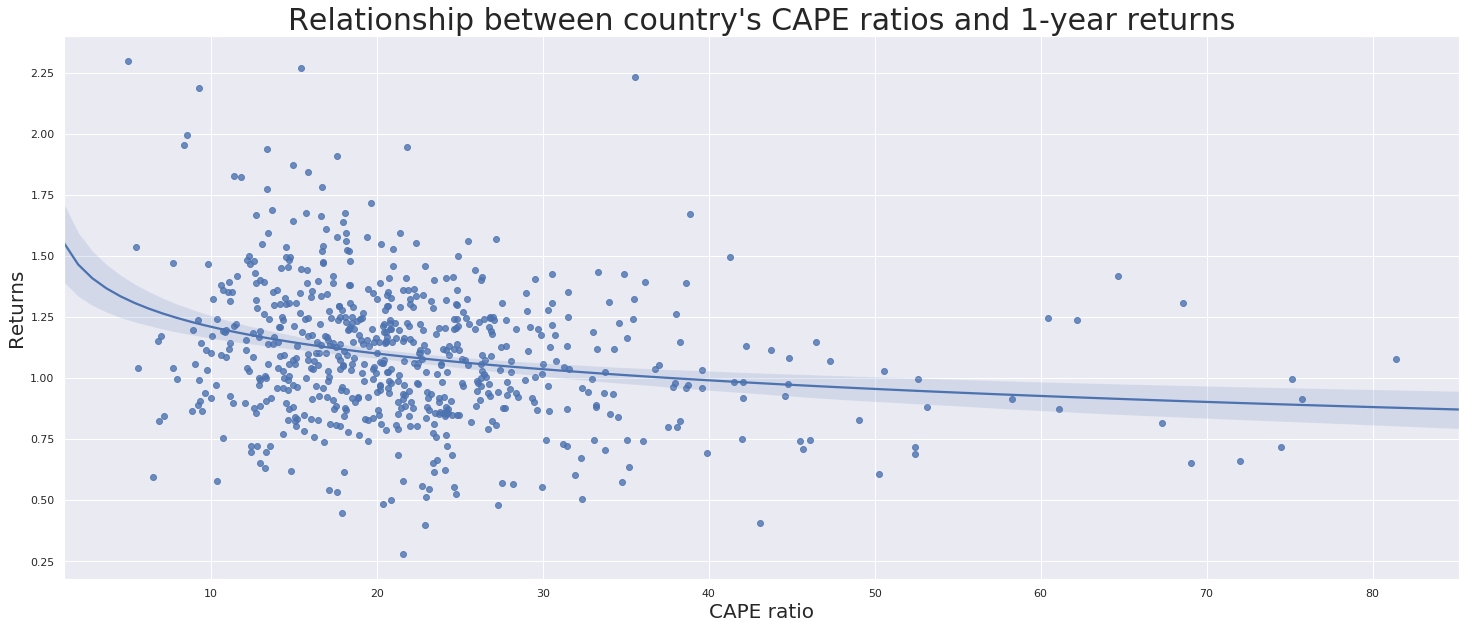

In [41]:
year1_returns = helper.multi_year_returns(year_percentage_returns, 1, adjust_yearly=False, adjust_inflation=True, inflation=asset_returns['Inflation'])
cape_1year,corr=helper.cape_return_mapping(yearly_cape, year1_returns)

sns.set(color_codes=True)
fig, ax = plt.subplots(figsize=(25,10)) 
ax.set_title('Relationship between country\'s CAPE ratios and 1-year returns', size= 30)
ax = sns.regplot(x="cape", y="return", data=cape_1year, logx=True)
plt.xlabel('CAPE ratio', size=20)
plt.ylabel('Returns', size=20);
print("1-year cape vs return correlation:", corr)

#### Comparing CAPE to 10-year returns

Since CAPE ratio is calculated with the past 10 years of earnings data. It might make more sense to use it to predict a longer term returns. Now lets calculate the 10-year inflation adjusted yearly returns per country and plot it against initial CAPE ratio to see how good of a predictor it is.

10-year cape vs return correlation: -0.5807469218399011


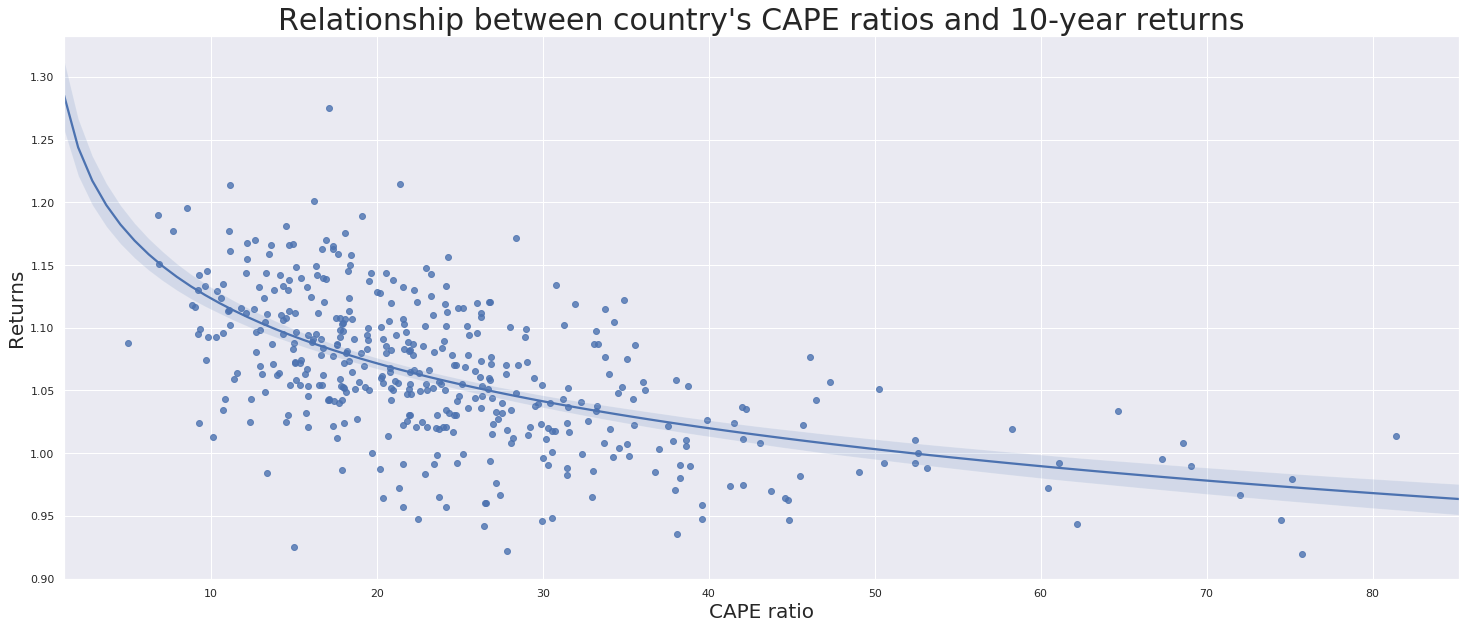

In [48]:
cape_10year,corr=helper.cape_return_mapping(yearly_cape, helper.multi_year_returns(year_percentage_returns, 10, adjust_yearly=True, adjust_inflation=True, inflation=asset_returns['Inflation']))

sns.set(color_codes=True)
fig, ax = plt.subplots(figsize=(25,10)) 
ax.set_title('Relationship between country\'s CAPE ratios and 10-year returns', size= 30)
ax = sns.regplot(x="cape", y="return", data=cape_10year, logx=True)
plt.xlabel('CAPE ratio', size=20)
plt.ylabel('Returns', size=20);
print("10-year cape vs return correlation:", corr)

The spearman correlation of the first plot was -.22, while the second one was of -.58. This shows two things, there is a negative correlation between CAPE and returns, and the correlation becomes stronger the father away we try to predict into the future. At what point does this increase peak? Let's calculate the correlations for all n-year returns and plot them out. 

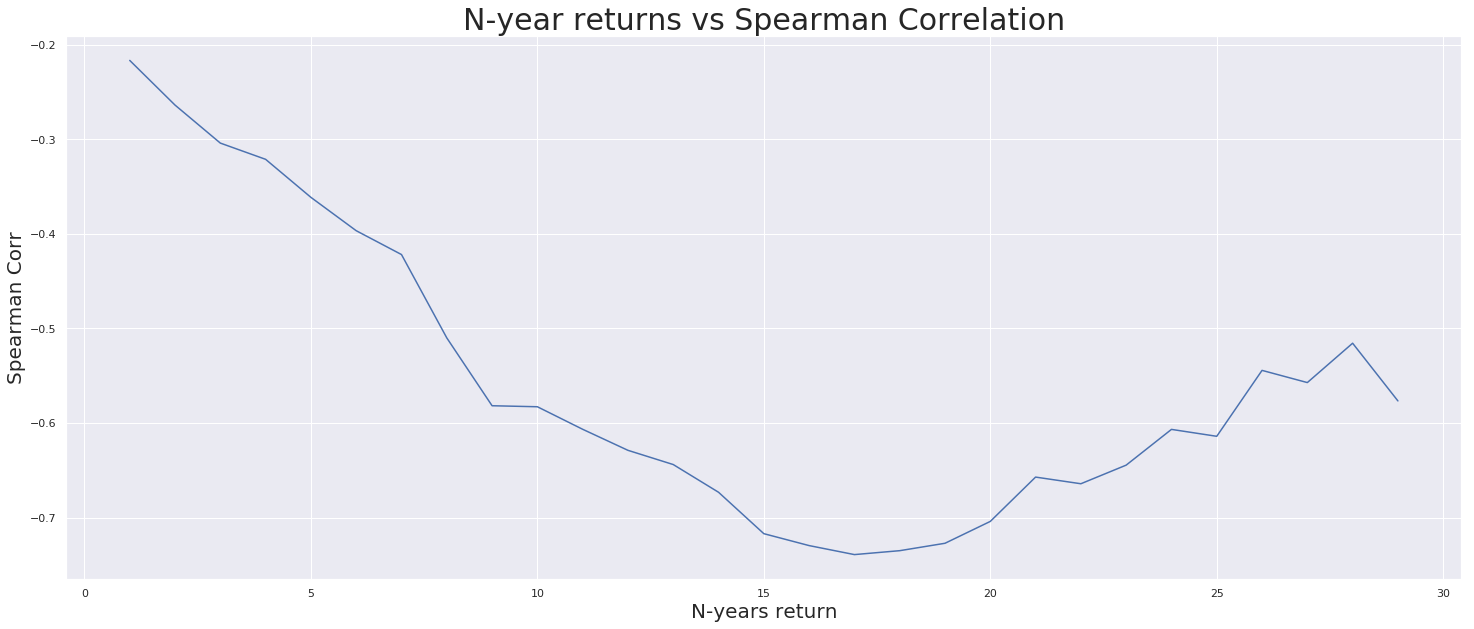

In [47]:
sns.set(color_codes=True)
fig, ax = plt.subplots(figsize=(25,10)) 
ax.set_title('N-year returns vs Spearman Correlation', size= 30)
sns.lineplot(x='years', y='spearman_corr', data=pd.DataFrame([(i, helper.cape_return_mapping(yearly_cape, helper.multi_year_returns(year_percentage_returns, i, adjust_yearly=False, adjust_inflation=False, inflation=asset_returns['Inflation']))[1]) for i in range(1,30)], columns=(['years', 'spearman_corr'])))
plt.xlabel('N-years return', size=20)
plt.ylabel('Spearman Corr', size=20);

The correlation between CAPE and future returns peaks when predicting for 17 years into the future at -.73. Let's plot this graph and see how it looks. 

10-year cape vs return correlation: -0.7215519582380833


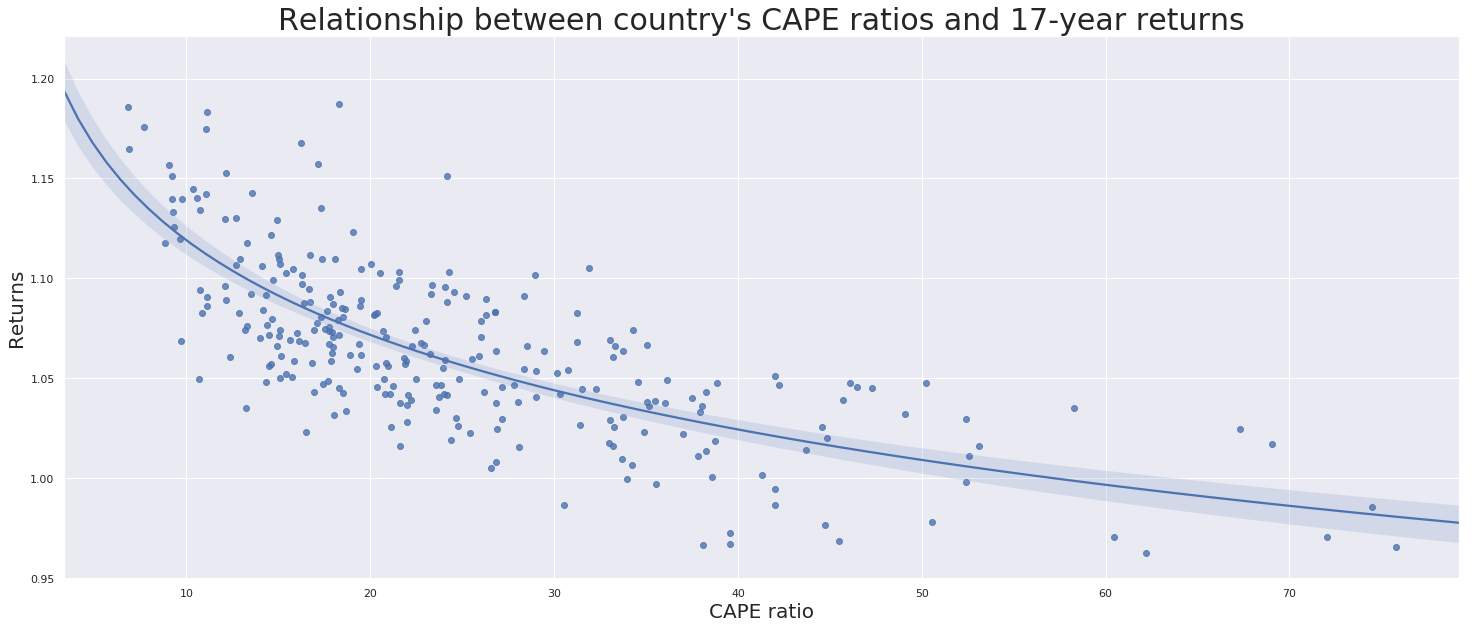

In [49]:
cape_10year,corr=helper.cape_return_mapping(yearly_cape, helper.multi_year_returns(year_percentage_returns, 17, adjust_yearly=True, adjust_inflation=True, inflation=asset_returns['Inflation']))

sns.set(color_codes=True)
fig, ax = plt.subplots(figsize=(25,10)) 
ax.set_title('Relationship between country\'s CAPE ratios and 17-year returns', size= 30)
ax = sns.regplot(x="cape", y="return", data=cape_10year, logx=True)
plt.xlabel('CAPE ratio', size=20)
plt.ylabel('Returns', size=20);
print("10-year cape vs return correlation:", corr)

### Conclusion
